Much of this file was adapted from https://www.kaggle.com/prasadperera/the-boston-housing-dataset

## Data Explanation
https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html

CRIM - per capita crime rate by town  
ZN - proportion of residential land zoned for lots over 25,000 sq.ft.  
INDUS - proportion of non-retail business acres per town.  
CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)  
NOX - nitric oxides concentration (parts per 10 million)  
RM - average number of rooms per dwelling  
AGE - proportion of owner-occupied units built prior to 1940  
DIS - weighted distances to five Boston employment centres  
RAD - index of accessibility to radial highways  
TAX - full-value property-tax rate per 10,000 dollars
PTRATIO - pupil-teacher ratio by town  
B - $1000(Bk - 0.63)^2$  where Bk is the proportion of African Americans by town  
LSTAT - % lower status of the population  
MEDV - Median value of owner-occupied homes in 1000's  

In [1]:
import numpy as np 
import pandas as pd 
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pylab

from pandas import read_csv
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
data = read_csv('housing.csv', header=None, delimiter=r"\s+", names=column_names)
print(data.head(5))

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2  


# EDA (Early Data Analysis)
- Always look at the data!

In [2]:
print(data.describe())

             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.148861    2.1057

### Visualize these stats!

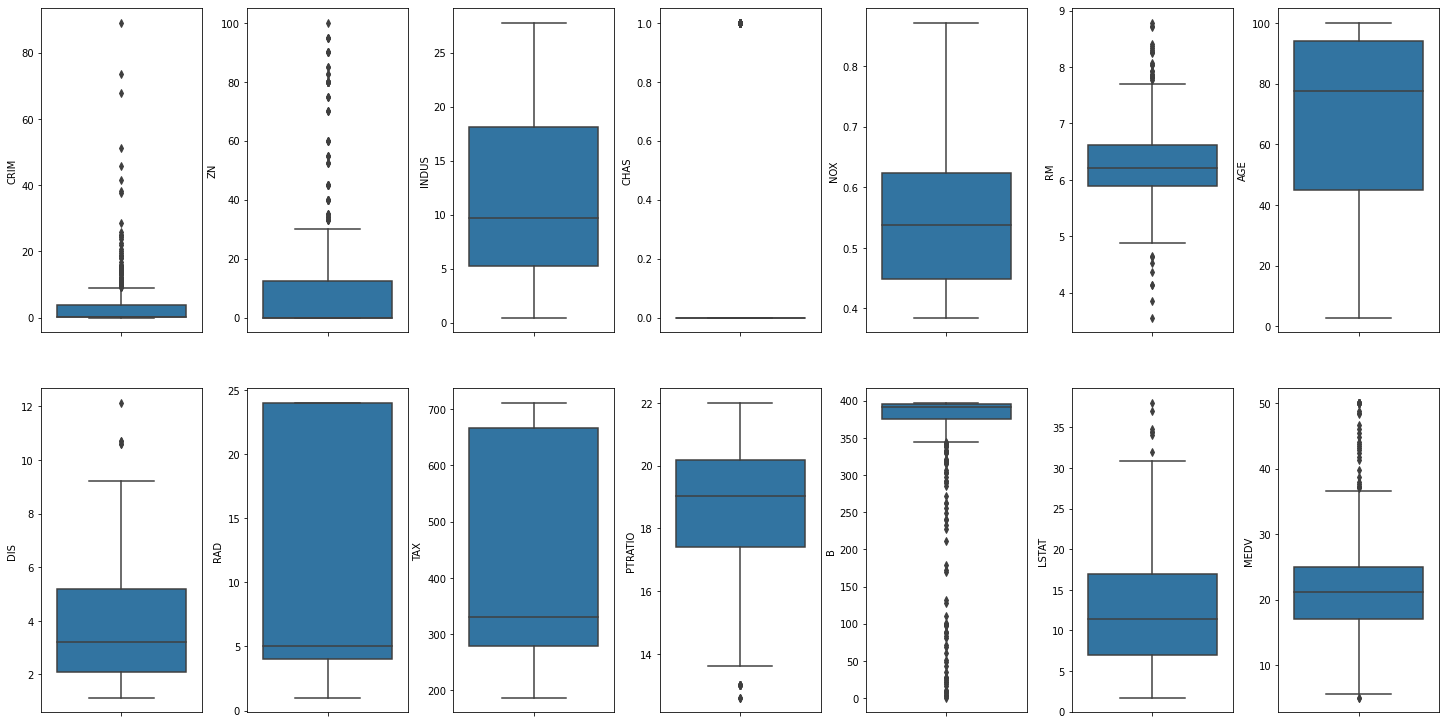

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in data.items():
    sns.boxplot(y=k, data=data, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

### How many outliers?

In [4]:
for k, v in data.items():
    q1 = v.quantile(0.25)
    q3 = v.quantile(0.75)
    irq = q3 - q1
    v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
    perc = np.shape(v_col)[0] * 100.0 / np.shape(data)[0]
    print("Column %s outliers = %.2f%%" % (k, perc))

Column CRIM outliers = 13.04%
Column ZN outliers = 13.44%
Column INDUS outliers = 0.00%
Column CHAS outliers = 100.00%
Column NOX outliers = 0.00%
Column RM outliers = 5.93%
Column AGE outliers = 0.00%
Column DIS outliers = 0.99%
Column RAD outliers = 0.00%
Column TAX outliers = 0.00%
Column PTRATIO outliers = 2.96%
Column B outliers = 15.22%
Column LSTAT outliers = 1.38%
Column MEDV outliers = 7.91%


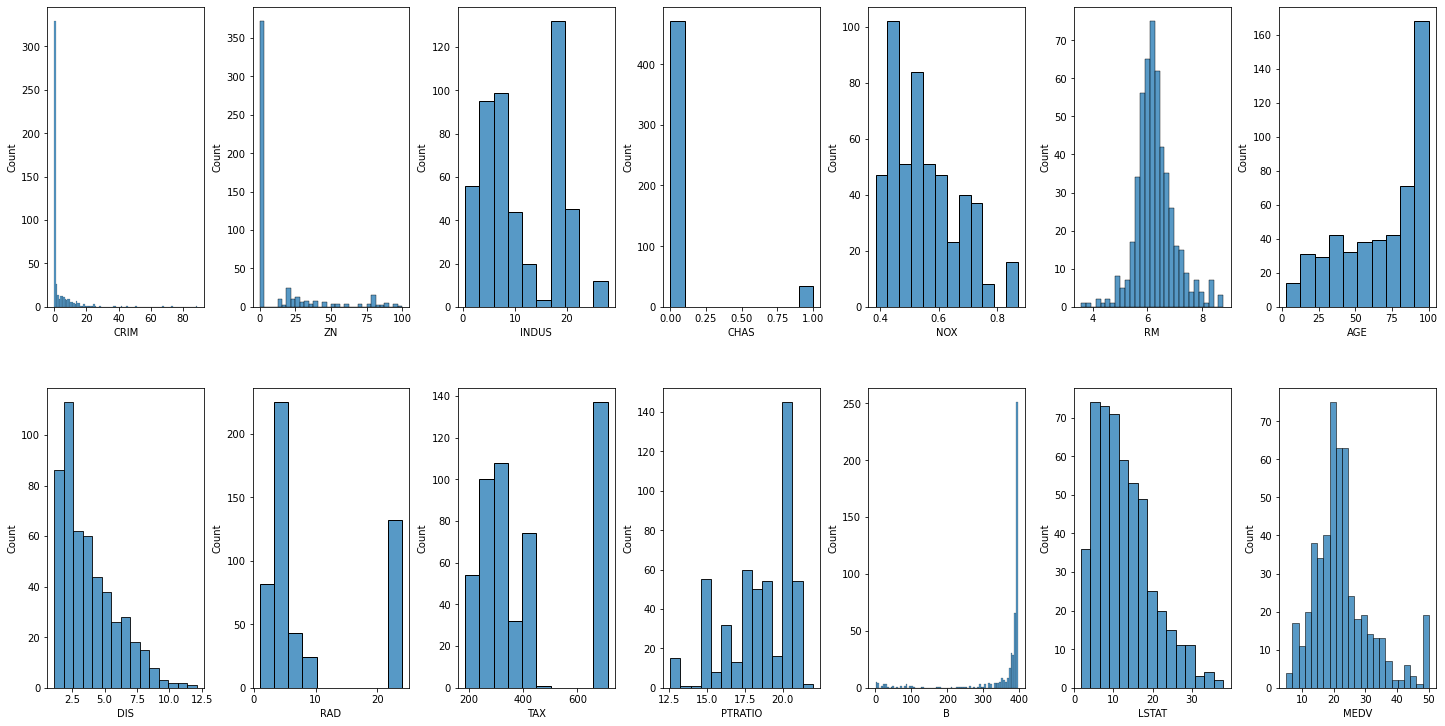

In [10]:
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in data.items():
    sns.histplot(v, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

<AxesSubplot:xlabel='CRIM', ylabel='Count'>

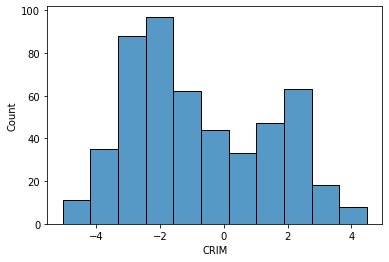

In [26]:
sns.histplot(np.log(data["CRIM"]))

<AxesSubplot:>

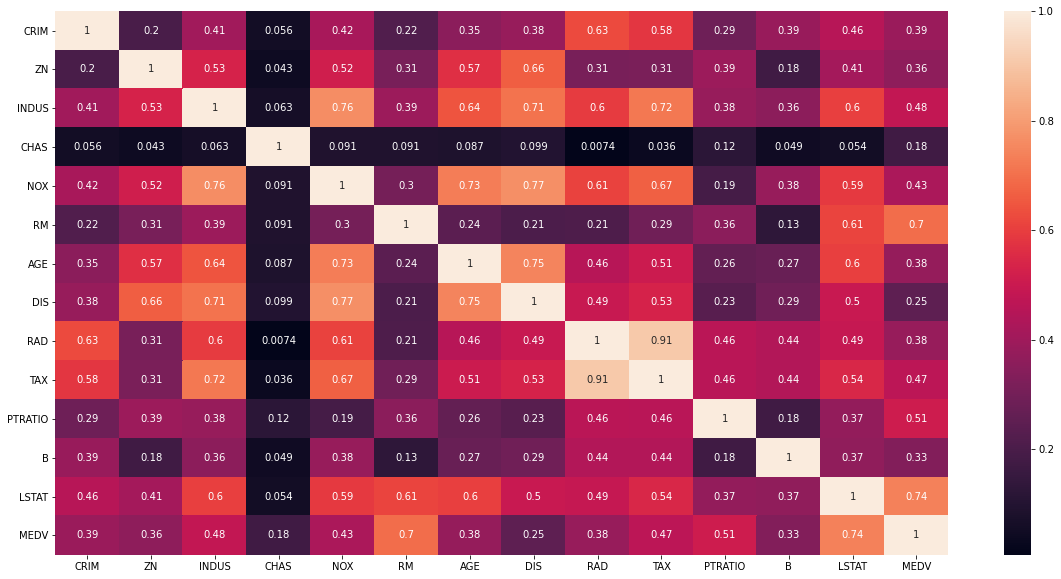

In [6]:
plt.figure(figsize=(20, 10))
sns.heatmap(data.corr().abs(),  annot=True)

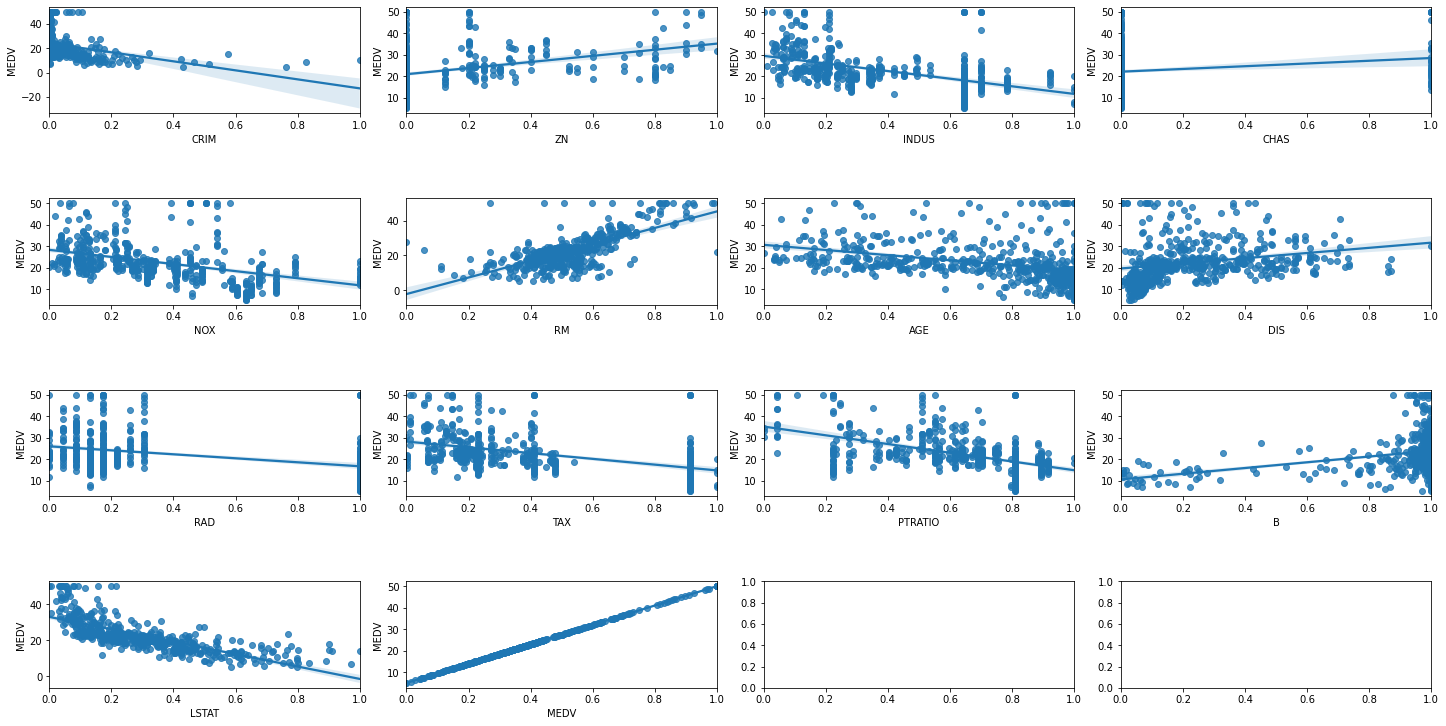

In [7]:
from sklearn import preprocessing
# Let's scale the columns before plotting them against MEDV
min_max_scaler = preprocessing.MinMaxScaler()
#column_sels = ['LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE']
x = data
y = data['MEDV']
x = pd.DataFrame(data=min_max_scaler.fit_transform(x), columns=x.columns)
fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(20, 10))
index = 0
axs = axs.flatten()
for i, k in enumerate(x.columns):
    sns.regplot(y=y, x=x[k], ax=axs[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

### Check for Missing Data

In [8]:
data.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

## Feature Engineering
- Modifying the data, this can be tricky and create errors
- EG. One variable is Hours_at_work_per_day, another is Pay_Per_Hour. The two features can be reduced to one by multiplying them, resulting in Days_Pay. 
    - This can make a better Y, or X. It combines the same information from two columns into one column, reducing standard errors for X's or changing the distribubtion for Y
- A good thing to do is to test square specefications and logs

In [17]:
added_data = data.copy()
for predictor in data.columns:
    if "CHAS" in predictor or "MEDV" in predictor: # skip dummy variable
        continue
    if min(added_data[predictor]) <=1:
        added_data[predictor+"_ln"] = np.log(added_data[predictor]+1) # add one to avoid log of 0
    else:
        added_data[predictor+"_ln"] = np.log(added_data[predictor])
        
    added_data[predictor+"_sq"] = added_data[predictor]**2
    
added_data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,...,RAD_ln,RAD_sq,TAX_ln,TAX_sq,PTRATIO_ln,PTRATIO_sq,B_ln,B_sq,LSTAT_ln,LSTAT_sq
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,...,0.693147,1,5.690359,87616.0,2.727853,234.09,5.986201,157529.6100,1.605430,24.8004
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,...,1.098612,4,5.488938,58564.0,2.879198,316.84,5.986201,157529.6100,2.212660,83.5396
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,...,1.098612,4,5.488938,58564.0,2.879198,316.84,5.975919,154315.4089,1.393766,16.2409
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,...,1.386294,9,5.402677,49284.0,2.928524,349.69,5.980479,155732.8369,1.078410,8.6436
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,...,1.386294,9,5.402677,49284.0,2.928524,349.69,5.986201,157529.6100,1.673351,28.4089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,...,0.693147,1,5.609472,74529.0,3.044522,441.00,5.973784,153656.1601,2.269028,93.5089
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,...,0.693147,1,5.609472,74529.0,3.044522,441.00,5.986201,157529.6100,2.206074,82.4464
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,...,0.693147,1,5.609472,74529.0,3.044522,441.00,5.986201,157529.6100,1.729884,31.8096
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,...,0.693147,1,5.609472,74529.0,3.044522,441.00,5.977492,154802.9025,1.868721,41.9904


In [18]:
X = added_data.drop(columns=["MEDV"])
y = pd.DataFrame(added_data["MEDV"])

In [19]:
X

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,...,RAD_ln,RAD_sq,TAX_ln,TAX_sq,PTRATIO_ln,PTRATIO_sq,B_ln,B_sq,LSTAT_ln,LSTAT_sq
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,...,0.693147,1,5.690359,87616.0,2.727853,234.09,5.986201,157529.6100,1.605430,24.8004
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,...,1.098612,4,5.488938,58564.0,2.879198,316.84,5.986201,157529.6100,2.212660,83.5396
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,...,1.098612,4,5.488938,58564.0,2.879198,316.84,5.975919,154315.4089,1.393766,16.2409
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,...,1.386294,9,5.402677,49284.0,2.928524,349.69,5.980479,155732.8369,1.078410,8.6436
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,...,1.386294,9,5.402677,49284.0,2.928524,349.69,5.986201,157529.6100,1.673351,28.4089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,...,0.693147,1,5.609472,74529.0,3.044522,441.00,5.973784,153656.1601,2.269028,93.5089
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,...,0.693147,1,5.609472,74529.0,3.044522,441.00,5.986201,157529.6100,2.206074,82.4464
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,...,0.693147,1,5.609472,74529.0,3.044522,441.00,5.986201,157529.6100,1.729884,31.8096
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,...,0.693147,1,5.609472,74529.0,3.044522,441.00,5.977492,154802.9025,1.868721,41.9904


## Feature Selecting

In this case, we will use [REFCV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html) to select the best model. It uses Cross Validation to remove one predictor at a time.

Some other ways to select predictors
- EDA Plots
- We can use [WLS](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.WLS.fit_regularized.html#statsmodels.regression.linear_model.WLS.fit_regularized) LASSO model.
- P-Value approach
    - Remove one predictor at a time, always removing the one with the highest p-value
- Many other approaches. Feature selection is an art.

## Cross Validation Recursive Feature Elimination

In [20]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [21]:
best = RFECV(LinearRegression(), cv=10)

In [22]:
model = best.fit(X, y)

In [23]:
model.ranking_

array([ 4, 15,  1,  1,  1,  1, 10,  1,  1,  8,  1, 14, 11,  1, 13,  2, 16,
        1,  6,  1,  1,  1,  1,  9, 17,  1,  3,  1,  5,  1, 18,  1,  7,  1,
       19,  1, 12])

In [24]:
model.support_

array([False, False,  True,  True,  True,  True, False,  True,  True,
       False,  True, False, False,  True, False, False, False,  True,
       False,  True,  True,  True,  True, False, False,  True, False,
        True, False,  True, False,  True, False,  True, False,  True,
       False])

In [27]:
model_str = "MEDV~"
for i in range(0,len(X.columns)):
    if model.support_[i]:
        model_str = f"{model_str}{X.columns[i]}+"
model_str = model_str[:len(model_str)-1]
model_str

'MEDV~INDUS+CHAS+NOX+RM+DIS+RAD+PTRATIO+CRIM_ln+INDUS_ln+NOX_ln+NOX_sq+RM_ln+RM_sq+DIS_ln+RAD_ln+TAX_ln+PTRATIO_ln+B_ln+LSTAT_ln'

### Interactive term

In [28]:
model_str+="+CHAS*RM"

In [30]:
ols_model = smf.ols(formula=model_str, data=added_data)
res = ols_model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     128.5
Date:                Sat, 18 Sep 2021   Prob (F-statistic):          3.01e-179
Time:                        13:00:45   Log-Likelihood:                -1374.6
No. Observations:                 506   AIC:                             2791.
Df Residuals:                     485   BIC:                             2880.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    191.4665     58.974      3.247      0.001      75.591     307.342
INDUS          0.2564      0.117      2.188      0.029       0.026       0.487
CHAS          17.5750      5.343      3.289      0.001       7.076      28.074
NOX        -3366.0442   1248.923     -2.695      0.007   -5820.011    -912.077
RM           -50.8305     27.581     -1.843      0.066    -105.023       3.362
DIS            0.5727      0.413      1.386      0.166      -0.239       1.385
RAD            0.4081      0.121      3.386      0.001       0.171       0.645
PTRATIO        4.4633      1.455      3.067      0.002       1.604       7.323
CRIM_ln       -2.9031      0.507     -5.726      0.000      -3.899      -1.907
INDUS_ln      -2.2431      1.220     -1.838      0.067      -4.641       0.154
NOX_ln      3917.6334   1453.304      2.696      0.007    1062.083    6773.184
NOX_sq       738.0229    279.932      2.636      0.009     187.994    1288.052
RM_ln         93.6172     83.204      1.125      0.261     -69.868     257.102
RM_sq          3.0366      1.121      2.709      0.007       0.834       5.239
DIS_ln        -7.2120      1.798     -4.011      0.000     -10.745      -3.679
RAD_ln         0.8184      1.079      0.758      0.449      -1.302       2.939
TAX_ln        -4.5979      1.001     -4.593      0.000      -6.565      -2.631
PTRATIO_ln   -91.0758     25.194     -3.615      0.000    -140.578     -41.573
B_ln           0.7138      0.260      2.748      0.006       0.203       1.224
LSTAT_ln      -8.2333      0.496    -16.604      0.000      -9.208      -7.259
CHAS:RM       -2.3347      0.816     -2.863      0.004      -3.937      -0.732
==============================================================================
Omnibus:                      137.403   Durbin-Watson:                   1.208
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1412.140
Skew:                           0.862   Prob(JB):                    2.28e-307
Kurtosis:                      11.001   Cond. No.                     5.66e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.66e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
predicted_y = res.predict(X)

Text(0.5, 1.0, 'Residual plot')

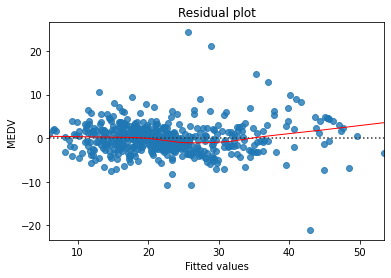

In [32]:
sns.residplot(x=predicted_y.values.reshape(-1),y='MEDV', data=added_data,lowess=True,
                                  line_kws={'color': 'red', 'lw': 1, 'alpha': 1})
plt.xlabel("Fitted values")
plt.title('Residual plot')

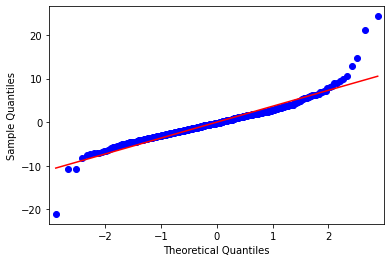

In [33]:
sm.qqplot(res.resid, line='s')
pylab.show()